In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


In [ ]:
DATA_DIR = "processed/"
SEQ_LENGTH = 30
NUM_CLASSES = 3
THRESHOLD = 0.005  # 0.5% for no change

#loading data
def load_and_preprocess(data_dir):
    files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith("_numerical_features_processed.csv")]
    all_data = []

    for file in files:
        stock_name = os.path.basename(file).split("_")[0]
        df = pd.read_csv(file, parse_dates=["Date"])
        df = df.sort_values("Date")
        df["Stock"] = stock_name
        df.fillna(method="ffill", inplace=True)
        df.dropna(inplace=True)
        if len(df) > SEQ_LENGTH + 1:
            all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

df = load_and_preprocess(DATA_DIR)

In [ ]:
#target
features = ["Volatility", "RSI", "P/E Ratio", "% Change Adj Close", "% Change Open",
            "% Change Volume", "% Change Volatility", "% Change RSI", "Log Open",
            "Log Adjusted Close", "Log Volume"]

#labeling
def label_direction(change, threshold=THRESHOLD):
    if change > threshold:
        return 1  #up
    elif change < -threshold:
        return 0  #down
    else:
        return 2  #no change

df["TargetClass"] = df["% Change Adj Close"].apply(label_direction)

#normalization
scaler_X = MinMaxScaler()
df[features] = scaler_X.fit_transform(df[features])


In [ ]:
X, y = [], []

for _, group in df.groupby("Stock"):
    group = group.sort_values("Date")
    if len(group) < SEQ_LENGTH + 1:
        continue
    for i in range(len(group) - SEQ_LENGTH):
        X.append(group.iloc[i:i+SEQ_LENGTH][features].values)
        y.append(group.iloc[i+SEQ_LENGTH]["TargetClass"])

X = np.array(X)
y = to_categorical(np.array(y), num_classes=NUM_CLASSES)

#train test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**Transformer** 

In [5]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

In [21]:
embed_dim = X_train.shape[2]
num_heads = 4
ff_dim = 128

inputs = Input(shape=(SEQ_LENGTH, embed_dim))
x = TransformerBlock(embed_dim, num_heads, ff_dim)(inputs, training=True)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)
x = GlobalAveragePooling1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(25, activation="relu")(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, min_lr=1e-6, verbose=1)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 30, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_16            │ (None, 30, 11)         │         5,078 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_17            │ (None, 30, 11)         │         5,078 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 11)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 50)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,109 (47.30 KB)

 Trainable params: 12,109 (47.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96609/96609 ━━━━━━━━━━━━━━━━━━━━ 2268s 23ms/step - accuracy: 0.3859 - loss: 1.0826 - val_accuracy: 0.4134 - val_loss: 1.0608 - learning_rate: 1.0000e-04
Epoch 2/50
96609/96609 ━━━━━━━━━━━━━━━━━━━━ 2120s 22ms/step - accuracy: 0.4275 - loss: 1.0506 - val_accuracy: 0.4308 - val_loss: 1.0404 - learning_rate: 1.0000e-04
Epoch 3/50
96609/96609 ━━━━━━━━━━━━━━━━━━━━ 1416s 15ms/step - accuracy: 0.4354 - loss: 1.0391 - val_accuracy: 0.4308 - val_loss: 1.0392 - learning_rate: 1.0000e-04
Epoch 4/50
96609/96609 ━━━━━━━━━━━━━━━━━━━━ 1181s 12ms/step - accuracy: 0.4375 - loss: 1.0347 - val_accuracy: 0.4294 - val_loss: 1.0378 - learning_rate: 1.0000e-04
Epoch 5/50
96609/96609 ━━━━━━━━━━━━━━━━━━━━ 1229s 13ms/step - accuracy: 0.4389 - loss: 1.0319 - val_accuracy: 0.4333 - val_loss: 1.0318 - learning_rate: 1.0000e-04
Epoch 6/50
96609/96609 ━━━━━━━━━━━━━━━━━━━━ 1255s 13ms/step - accuracy: 0.4392 - loss: 1.0301 - val_accuracy: 0.4342 - val_loss: 1.0317 - learning_rate: 1.0000e-04
Epoch 7/50
96609

KeyboardInterrupt: 

In [ ]:
#check for distribution of the data
import numpy as np
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(994310), np.int64(1): np.int64(1054752), np.int64(2): np.int64(1042404)}


c:\Users\Searc\OneDrive\CSE\CS7643\CS7643\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[[ 27842 120793 105426]
 [ 23758 135622 108576]
 [ 14134 110279 126437]]
              precision    recall  f1-score   support

           0       0.42      0.11      0.17    254061
           1       0.37      0.51      0.43    267956
           2       0.37      0.50      0.43    250850

    accuracy                           0.38    772867
   macro avg       0.39      0.37      0.34    772867
weighted avg       0.39      0.38      0.34    772867



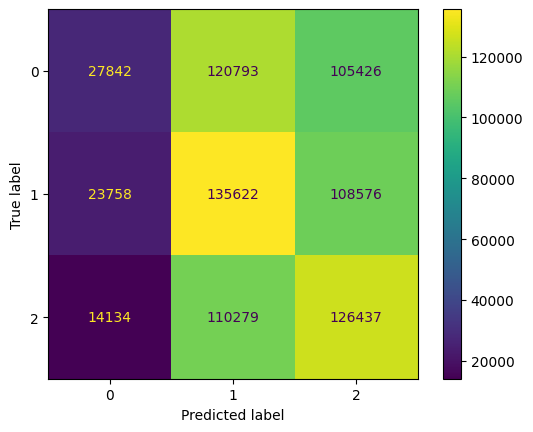

In [ ]:
#logistic regression for comparison
X_train_base = X_train[:, -1, :]
X_test_base = X_test[:, -1, :]


y_train_base = np.argmax(y_train, axis=1)
y_test_base = np.argmax(y_test, axis=1)

#scaling
from sklearn.preprocessing import StandardScaler
scaler_base = StandardScaler()
X_train_base = scaler_base.fit_transform(X_train_base)
X_test_base = scaler_base.transform(X_test_base)

#train
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_base, y_train_base)

#evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred_base = log_reg.predict(X_test_base)

print(confusion_matrix(y_test_base, y_pred_base))
print(classification_report(y_test_base, y_pred_base))
ConfusionMatrixDisplay(confusion_matrix(y_test_base, y_pred_base)).plot()

-----